In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Visualizaçao inicial

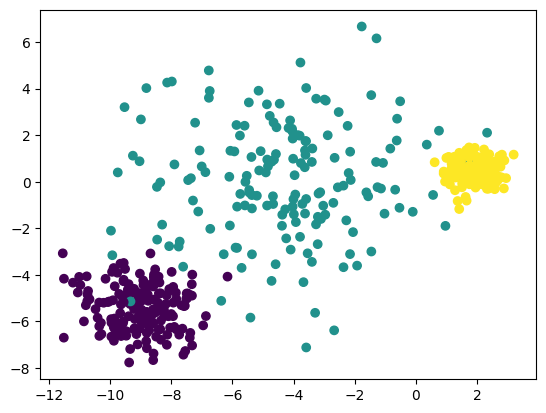

In [12]:
for csv in [f'data_{i}.csv' for i in range(2, 3)]:
    df = pd.read_csv(f'sinteticos2/{csv}')
    plt.scatter(df['x'], df['y'], c=df['label'])
    plt.show()

# K-Means 2 aproximativo guloso

In [14]:
def greedy_k_means(data, k, type=2):
    def dist(p1, p2):
        """Minkowski distance between two points"""
        return np.sum(np.abs(p1 - p2)**type)**(1/type)
    
    def closest(p, centers,):
        """"Return the index of the closest center to a point"""
        return np.argmin([dist(p, c) for c in centers])
    centers = []
    centers.append(data.sample().values[0,:2])
    while len(centers) < k:
        data['closest_i'] = data.apply(lambda x: closest(x.values[:2], centers), axis=1)
        data['closest'] = data.apply(lambda x: dist(x.values[:2], centers[int(x['closest_i'])]), axis=1)
        pos = data['closest'].argmax()
        centers += [data.iloc[pos].values[:2]]
    else:
        # for i in range(k):
        #     assigned_points = data[data['closest_i'] == i].iloc[:, :2].values
        #     if len(assigned_points) > 0:
        #         centers[i] = np.mean(assigned_points, axis=0)
        data['closest_i'] = data.apply(lambda x: closest(x.values[:2], centers), axis=1)
        data['closest'] = data.apply(lambda x: dist(x.values[:2], centers[int(x['closest_i'])]), axis=1)

    return centers, data['closest'].max(), data['closest_i']

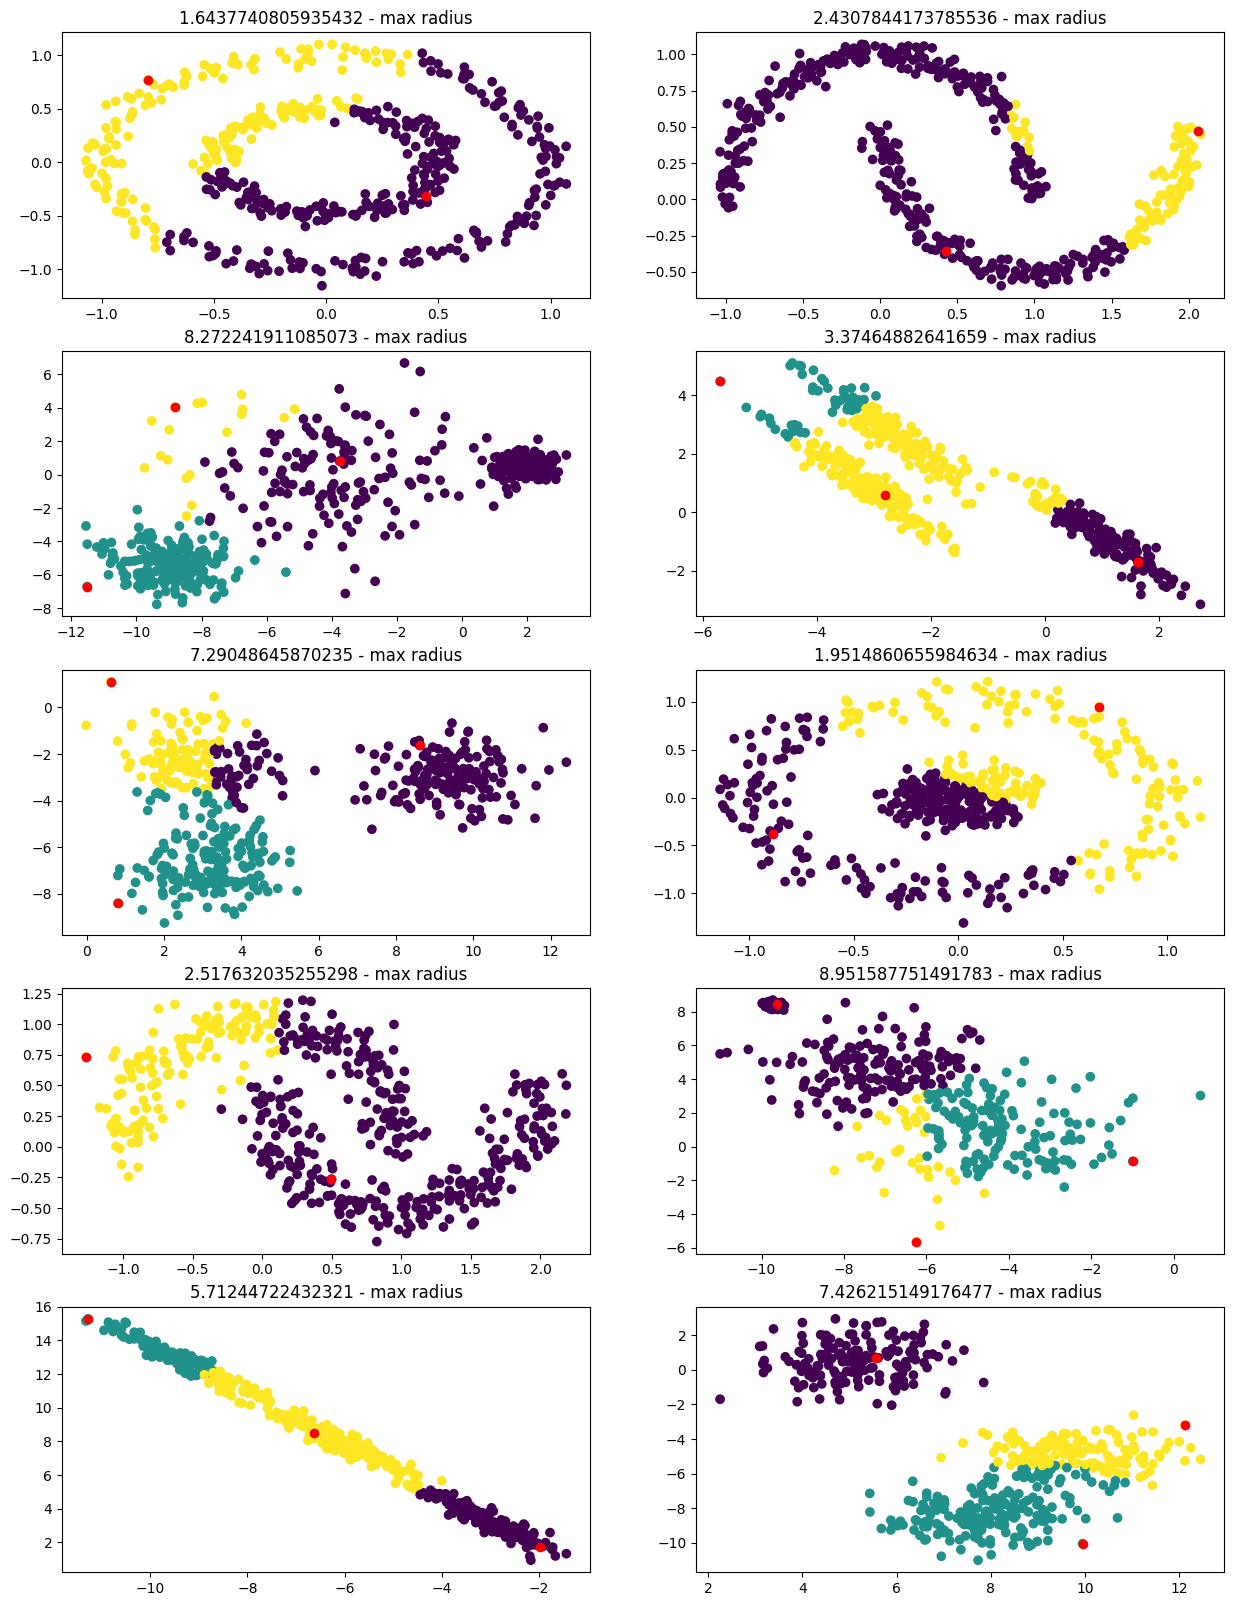

In [15]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
predict = 0


for i,csv in enumerate([f'data_{i}.csv' for i in range(10)]):
    df = pd.read_csv(f'sinteticos2/{csv}')

    n = len(df['label'].unique())
    centers, max_r, predict  = greedy_k_means(df, n,1)

    ax[i//2,i%2].scatter(df['x'], df['y'], c=predict)
    ax[i//2,i%2].scatter([c[0] for c in centers], [c[1] for c in centers], c='red')
    ax[i//2,i%2].set_title(f'{max_r} - max radius')

plt.show()

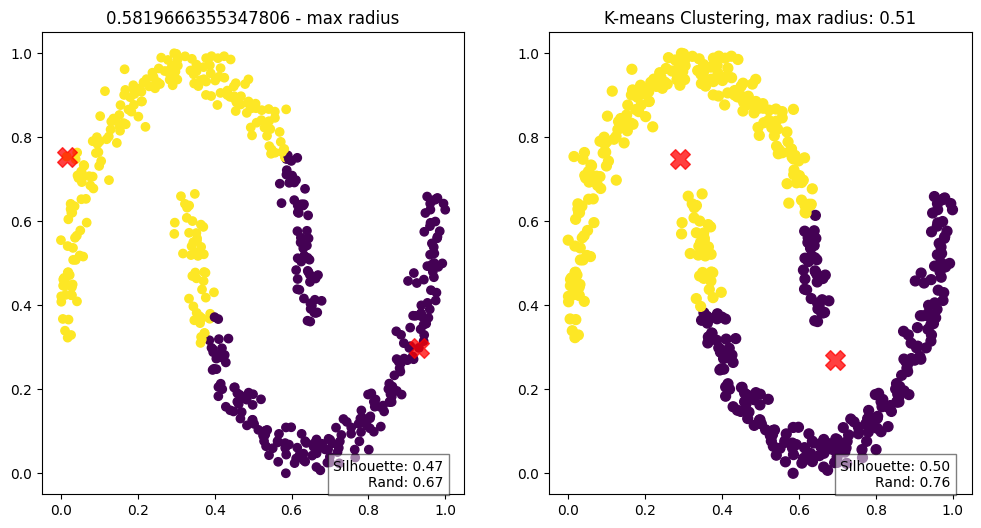

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

df = pd.read_csv(f'sinteticos2/data_{1}.csv')
for column in df.columns[:2]:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# Configurar o tamanho da figura
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Parte 1: Algoritmo greedy_k_means
n = len(df['label'].unique())
centers, max_r, predict = greedy_k_means(df, n, 2)
ss = silhouette_score(df.iloc[:,:2], predict)
rs = rand_score(df['label'], predict)

# Plotar o resultado do greedy_k_means
ax[0].scatter(df['x'], df['y'], c=predict)
ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
ax[0].set_title(f'{max_r} - max radius')
ax[1].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[0].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))

# Parte 2: K-means do sklearn
X, y = df.iloc[:, :2], df['label']
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
labels = kmeans.fit_predict(X)
distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values[:,:2])])

# Imprimir métricas
sil_score = silhouette_score(X.values, labels)
rand_score_value = rand_score(y, labels)

# Plotar o resultado do K-means
ax[1].scatter(X.values[:, 0], X.values[:, 1], c=labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[1].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))
# Configurar título e rótulos
ax[1].set_title(f'K-means Clustering, max radius: {mar_r_sklearn:.2f}')

# Exibir os gráficos
plt.show()

# Gerando metricas

In [17]:
type=2

In [18]:
metrics = []
csv_files = [f'data_{i}.csv' for i in range(10)]
for i,csv in enumerate(tqdm(csv_files)):
    df = pd.read_csv(f'sinteticos2/{csv}')
    for column in df.columns[:2]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

    n = len(df['label'].unique())
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        centers, max_r, predict = greedy_k_means(df, n,type)
        end = time.time()
        radius.append(max_r)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(df.iloc[:,:2], predict))
        rand_s.append(rand_score(df['label'], predict))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


In [19]:
df_greedy.to_csv(f'sinteticos2/greedy_metrics_{type}.csv', index=False)
df_greedy

,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.662653,0.044413,0.027420,0.340556,0.016941,0.501649,0.003020
1,0.684671,0.044701,0.025009,0.415088,0.097488,0.686446,0.114134
2,0.545289,0.045798,0.050415,0.535103,0.081471,0.793869,0.041421
3,0.402001,0.039947,0.061527,0.395796,0.081869,0.683509,0.071175
4,0.492199,0.031570,0.041267,0.559150,0.057557,0.885414,0.051096
5,0.615435,0.077748,0.024383,0.331468,0.059843,0.534894,0.019582
6,0.637199,0.056628,0.024343,0.401778,0.091476,0.683155,0.082638
7,0.481316,0.046883,0.039951,0.397410,0.047559,0.615213,0.113271
8,0.334307,0.040267,0.052821,0.543906,0.053701,0.826894,0.050482
9,0.450717,0.035484,0.053837,0.558861,0.035855,0.897053,0.066698


In [20]:
metrics = []
csv_files = [f'data_{i}.csv' for i in range(10)]
for i,csv in enumerate(tqdm(csv_files)):
    df = pd.read_csv(f'sinteticos2/{csv}')
    for column in df.columns[:2]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    #print(df)
    X, y = df.iloc[:,:2], df['label']
    n = len(df['label'].unique())
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
        labels = kmeans.fit_predict(X)
        #distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
        distance = lambda x1, x2: np.sum(np.abs(x1 - x2)**type)**(1/type)
        mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values[:,:2])])
        end = time.time()
        radius.append(mar_r_sklearn)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(X.values, labels))
        rand_s.append(rand_score(y, labels))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_sklearn = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])
df_sklearn.to_csv(f'sinteticos2/sklearn_metrics_{type}.csv', index=False)
df_sklearn

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.519778,1.110223e-16,0.040354,0.363096,1.110223e-16,0.499006,1.665335e-16
1,0.505093,1.110223e-16,0.039198,0.499026,1.110223e-16,0.761611,2.220446e-16
2,0.476244,0.000000e+00,0.040065,0.654127,2.220446e-16,0.904954,0.000000e+00
3,0.341353,1.110223e-16,0.041592,0.501585,0.000000e+00,0.806333,0.000000e+00
4,0.387091,0.000000e+00,0.043672,0.654252,1.110223e-16,0.986814,1.110223e-16
5,0.529355,0.000000e+00,0.042846,0.276320,0.000000e+00,0.508818,1.110223e-16
6,0.516528,1.110223e-16,0.043816,0.484203,5.551115e-17,0.747303,2.220446e-16
7,0.465411,5.551115e-17,0.039904,0.590386,1.110223e-16,0.903022,2.220446e-16
8,0.282000,0.000000e+00,0.006171,0.691703,2.220446e-16,0.968737,2.220446e-16
9,0.327671,1.110223e-16,0.030970,0.609371,1.110223e-16,0.969026,0.000000e+00
